### Steel Plate Defect Prediction
## Your Goal:
* Predict the probability of various defects on steel plates.

Submissions are evaluated using area under the ROC curve using the predicted probabilities and the ground truth targets.

To calculate the final score, AUC is calculated for each of the 7 defect categories and then averaged. In other words, the score is the average of the individual AUC of each predicted column.

In [106]:
!pip install lightgbm

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier


In [108]:
train_df = pd.read_csv('drive/MyDrive/train_steel_plate.csv')
train_df.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


In [109]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19219 entries, 0 to 19218
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     19219 non-null  int64  
 1   X_Minimum              19219 non-null  int64  
 2   X_Maximum              19219 non-null  int64  
 3   Y_Minimum              19219 non-null  int64  
 4   Y_Maximum              19219 non-null  int64  
 5   Pixels_Areas           19219 non-null  int64  
 6   X_Perimeter            19219 non-null  int64  
 7   Y_Perimeter            19219 non-null  int64  
 8   Sum_of_Luminosity      19219 non-null  int64  
 9   Minimum_of_Luminosity  19219 non-null  int64  
 10  Maximum_of_Luminosity  19219 non-null  int64  
 11  Length_of_Conveyer     19219 non-null  int64  
 12  TypeOfSteel_A300       19219 non-null  int64  
 13  TypeOfSteel_A400       19219 non-null  int64  
 14  Steel_Plate_Thickness  19219 non-null  int64  
 15  Ed

In [110]:
train_df.describe()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,19219.000000,19219.000000,19219.000000,1.921900e+04,1.921900e+04,19219.000000,19219.000000,19219.000000,1.921900e+04,19219.000000,...,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000
mean,9609.000000,709.854675,753.857641,1.849756e+06,1.846605e+06,1683.987616,95.654665,64.124096,1.918467e+05,84.808419,...,0.102742,-0.138382,0.571902,0.076279,0.059837,0.178573,0.029554,0.025235,0.247828,0.341225
std,5548.191747,531.544189,499.836603,1.903554e+06,1.896295e+06,3730.319865,177.821382,101.054178,4.420247e+05,28.800344,...,0.487681,0.120344,0.332219,0.265450,0.237190,0.383005,0.169358,0.156844,0.431762,0.474133
min,0.000000,0.000000,4.000000,6.712000e+03,6.724000e+03,6.000000,2.000000,1.000000,2.500000e+02,0.000000,...,-0.988400,-0.885000,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4804.500000,49.000000,214.000000,6.574680e+05,6.575020e+05,89.000000,15.000000,14.000000,9.848000e+03,70.000000,...,-0.272700,-0.192500,0.253200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9609.000000,777.000000,796.000000,1.398169e+06,1.398179e+06,168.000000,25.000000,23.000000,1.823800e+04,90.000000,...,0.111100,-0.142600,0.472900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14413.500000,1152.000000,1165.000000,2.368032e+06,2.362511e+06,653.000000,64.000000,61.000000,6.797800e+04,105.000000,...,0.529400,-0.084000,0.999400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,19218.000000,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,7553.000000,903.000000,1.159141e+07,196.000000,...,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [111]:
train_df.isnull().sum()

id                       0
X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scatch                 0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
dtype: int64

In [112]:
train_df.shape

(19219, 35)

In [113]:
train_df['x_by_y'] = train_df['X_Perimeter'] / train_df['Y_Perimeter']

In [114]:
train_df['Pixel_area_by_luminosity'] = train_df['Pixels_Areas'] / train_df['Sum_of_Luminosity']

In [115]:
train_df[['Bumps','Pastry','Z_Scratch','K_Scatch','Stains','Dirtiness','Other_Faults']].describe()

,Bumps,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Other_Faults
count,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000
mean,0.247828,0.076279,0.059837,0.178573,0.029554,0.025235,0.341225
std,0.431762,0.265450,0.237190,0.383005,0.169358,0.156844,0.474133
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [116]:
targets = ['id','Pastry','Z_Scratch','K_Scatch','Bumps','Stains','Dirtiness','Other_Faults']

In [117]:
targets_df = train_df[targets]

In [118]:
targets_df.head()

,id,Pastry,Z_Scratch,K_Scatch,Bumps,Stains,Dirtiness,Other_Faults
0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,1
2,2,0,0,1,0,0,0,0
3,3,0,0,1,0,0,0,0
4,4,0,0,0,0,0,0,1


In [119]:
# move `Bumps` to later in later column
targets_df = targets_df[['id','Pastry','Z_Scratch','K_Scatch','Bumps','Stains','Dirtiness','Other_Faults']]
targets_df.head()

,id,Pastry,Z_Scratch,K_Scatch,Bumps,Stains,Dirtiness,Other_Faults
0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,1
2,2,0,0,1,0,0,0,0
3,3,0,0,1,0,0,0,0
4,4,0,0,0,0,0,0,1


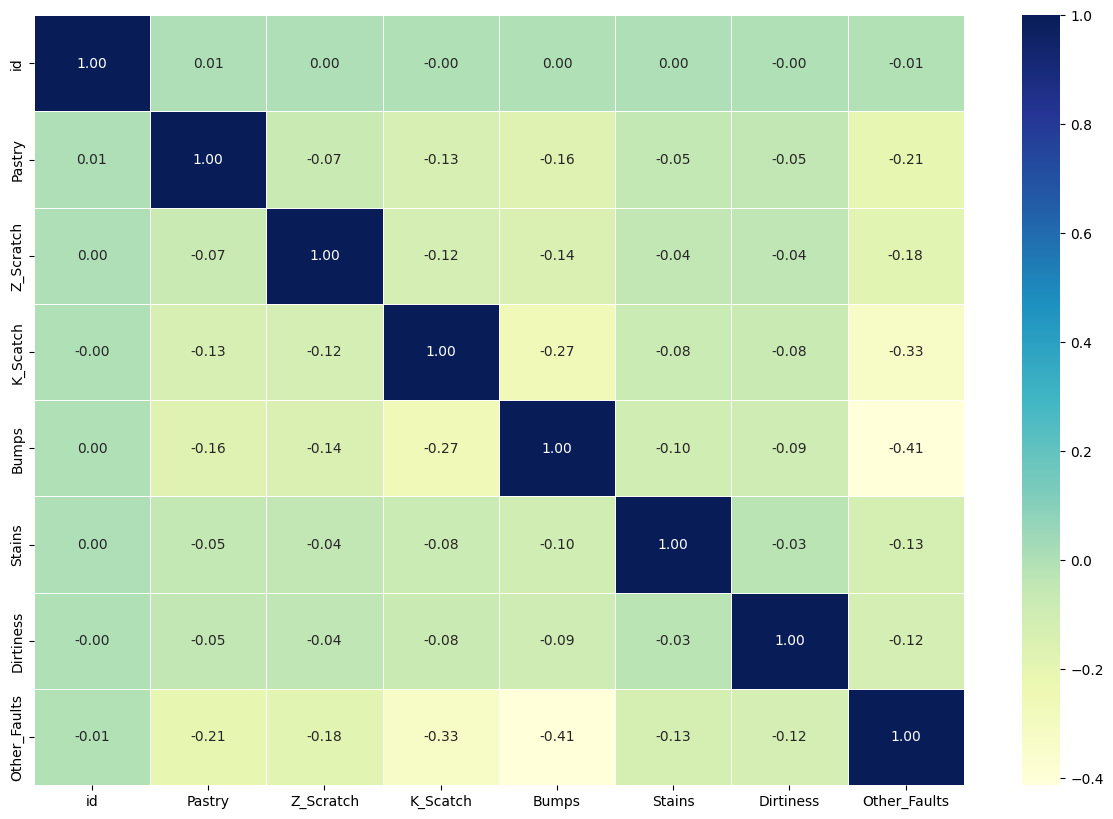

In [120]:
corr_matrix = targets_df.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,
                annot=True,
                linewidths=0.5,
                fmt='.2f',
                cmap= 'YlGnBu');

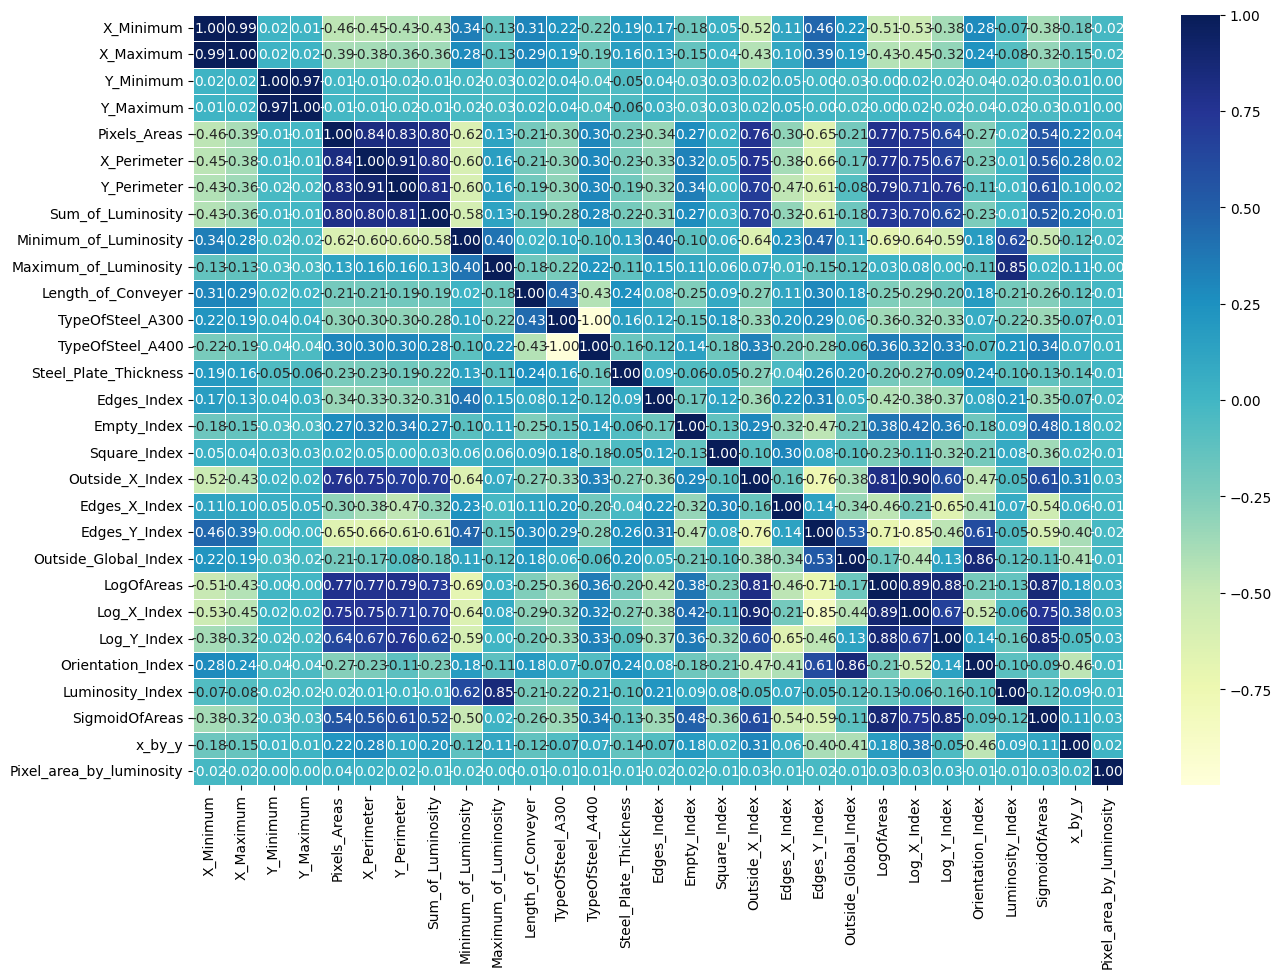

In [121]:
df_no_targets = train_df.drop(columns = targets)
corr_matrix = df_no_targets.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,
                annot=True,
                linewidths=0.5,
                fmt='.2f',
                cmap= 'YlGnBu');

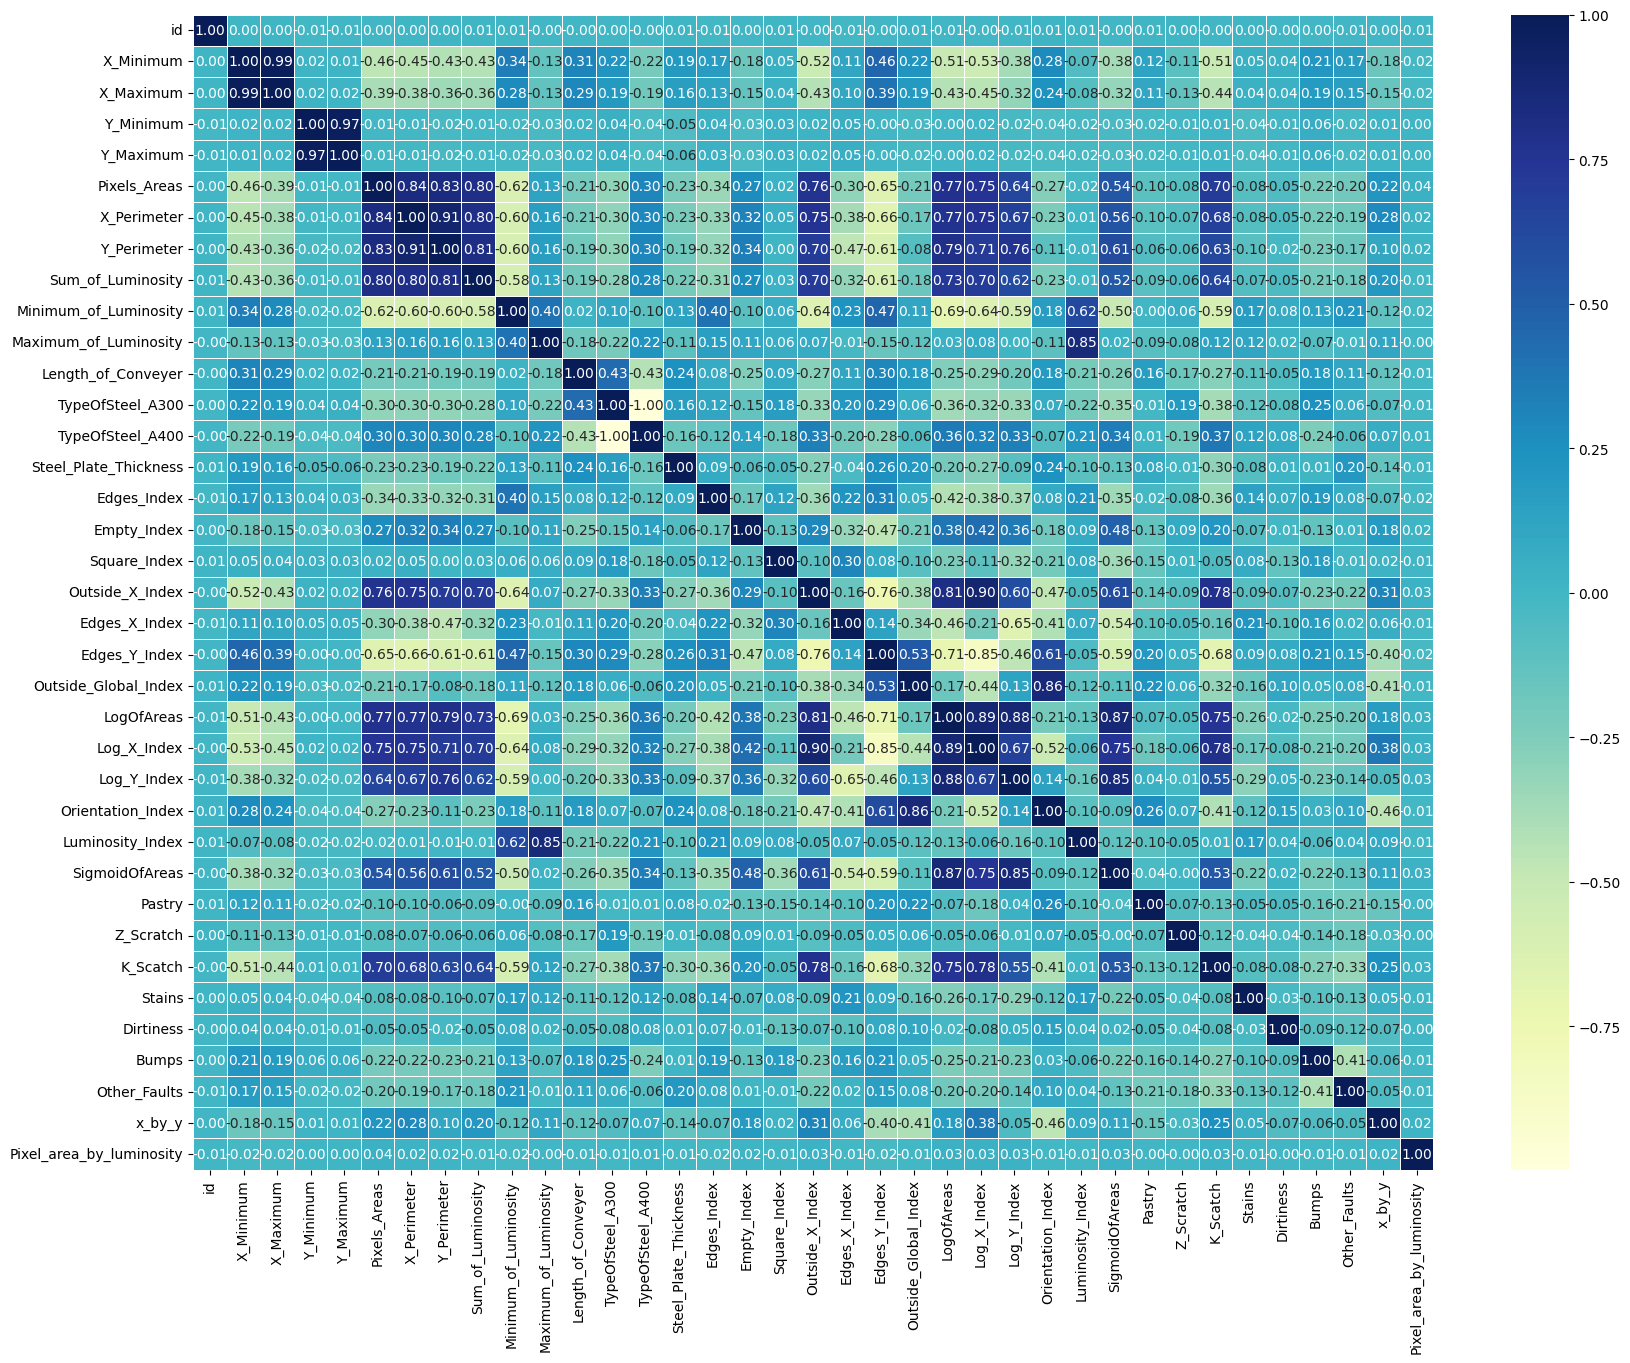

In [122]:
corr_matrix = train_df.corr()
fig, ax = plt.subplots(figsize=(20,15))
ax = sns.heatmap(corr_matrix,
                annot=True,
                linewidths=0.5,
                fmt='.2f',
                cmap= 'YlGnBu');

In [123]:
df_luminosity_targets = train_df[['Sum_of_Luminosity','Minimum_of_Luminosity', 'Maximum_of_Luminosity','Luminosity_Index','Bumps','Pastry','Z_Scratch','K_Scatch','Stains','Dirtiness','Other_Faults']]

In [124]:
df_luminosity_targets.head()

,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Luminosity_Index,Bumps,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Other_Faults
0,2274,113,140,-0.0104,0,0,0,0,1,0,0
1,44478,70,111,-0.2997,0,0,0,0,0,0,1
2,1311391,29,141,-0.0944,0,0,0,1,0,0,0
3,3202,114,134,-0.0402,0,0,0,1,0,0,0
4,48231,82,111,-0.2455,0,0,0,0,0,0,1


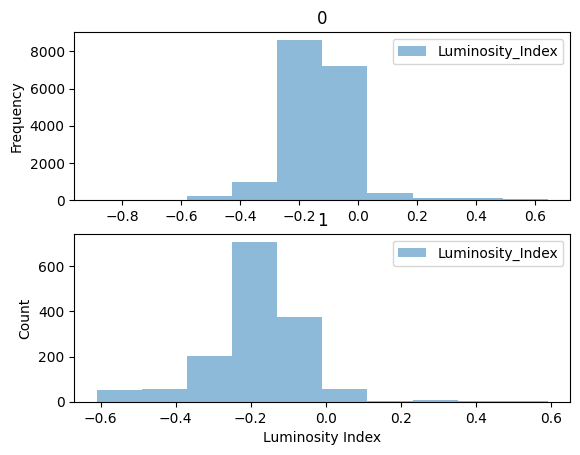

In [125]:
# @title Luminosity Index Distribution by Pastry

df_luminosity_targets.plot.hist(column='Luminosity_Index', by='Pastry', alpha=0.5)
plt.xlabel('Luminosity Index')
_ = plt.ylabel('Count')

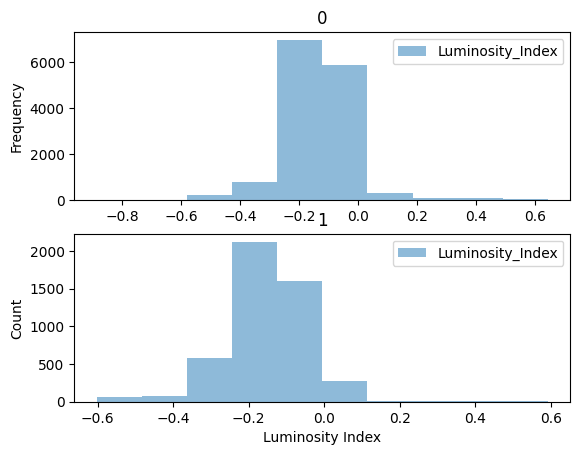

In [126]:

df_luminosity_targets.plot.hist(column='Luminosity_Index', by='Bumps', alpha=0.5)
plt.xlabel('Luminosity Index')
_ = plt.ylabel('Count')

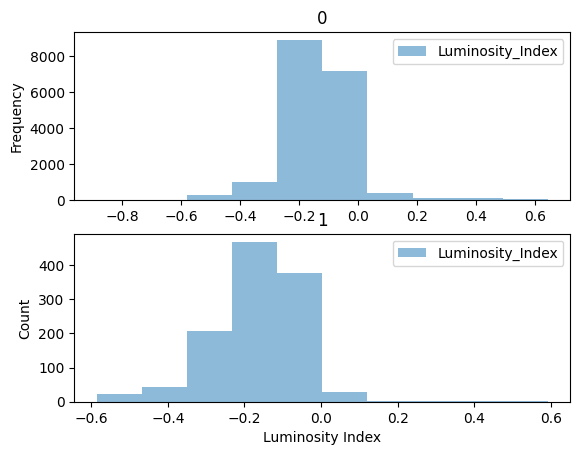

In [127]:

df_luminosity_targets.plot.hist(column='Luminosity_Index', by='Z_Scratch', alpha=0.5)
plt.xlabel('Luminosity Index')
_ = plt.ylabel('Count')

In [128]:
# Size figures/groupings
df_size = train_df[['X_Minimum', 'X_Maximum','Y_Minimum','Y_Maximum','Pixels_Areas','X_Perimeter','Y_Perimeter','Length_of_Conveyer','Steel_Plate_Thickness','LogOfAreas','SigmoidOfAreas']]
df_size

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Length_of_Conveyer,Steel_Plate_Thickness,LogOfAreas,SigmoidOfAreas
0,584,590,909972,909977,16,8,5,1358,50,1.2041,0.1417
1,808,816,728350,728372,433,20,54,1687,80,2.6365,0.9491
2,39,192,2212076,2212144,11388,705,420,1400,40,4.0564,1.0000
3,781,789,3353146,3353173,210,16,29,1387,40,2.3222,0.4025
4,1540,1560,618457,618502,521,72,67,1692,300,2.7694,0.9998
...,...,...,...,...,...,...,...,...,...,...,...
19214,749,757,143210,143219,17,4,4,1360,50,1.2305,0.2901
19215,723,735,2488529,2488541,231,17,26,1652,70,2.3636,0.5378
19216,6,31,1578055,1578129,780,114,98,1358,200,2.8921,0.9997
19217,9,18,1713172,1713184,126,13,26,1692,60,2.1004,0.3509


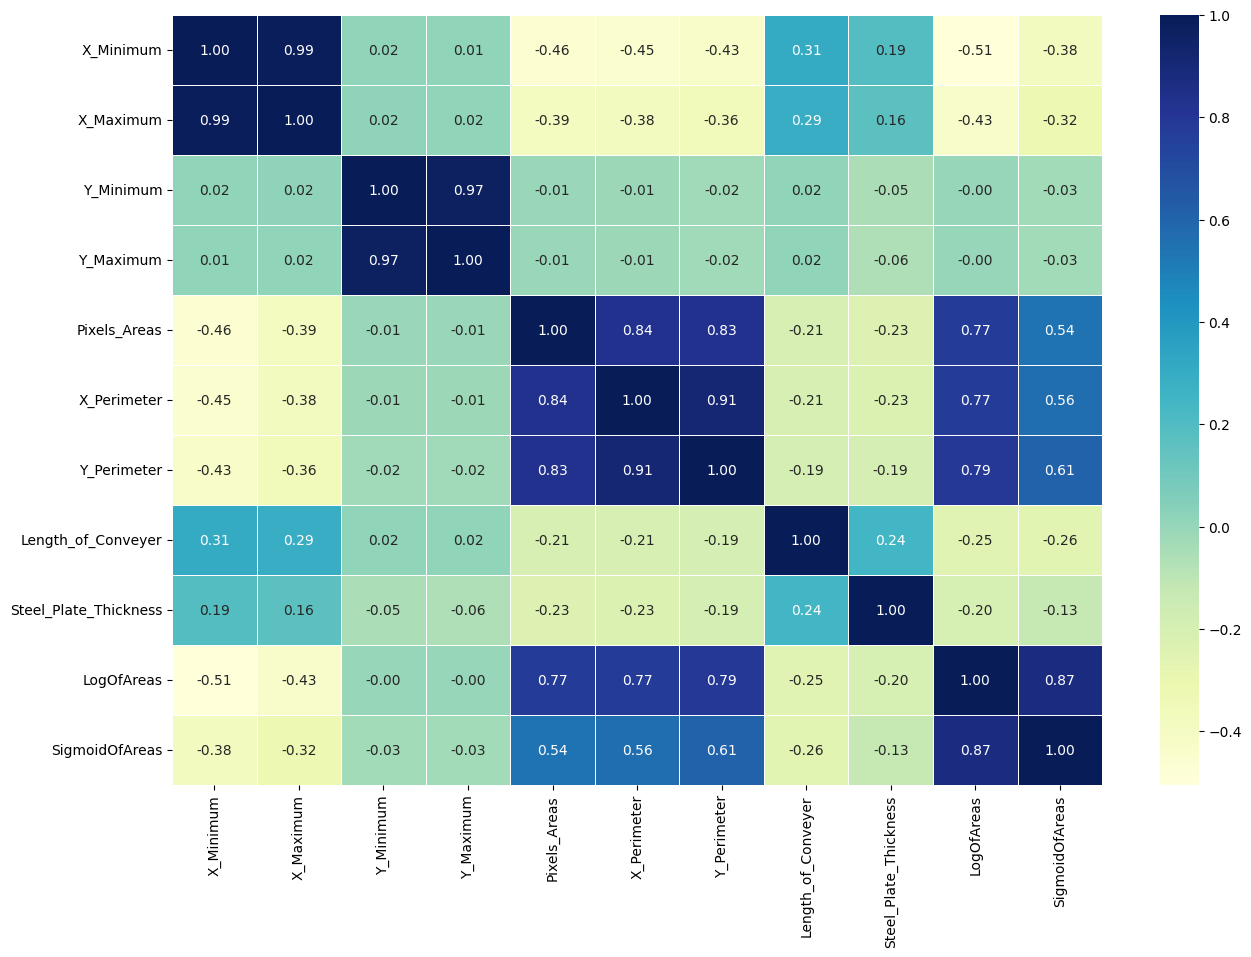

In [129]:
corr_matrix = df_size.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,
                annot=True,
                linewidths=0.5,
                fmt='.2f',
                cmap= 'YlGnBu');

In [130]:
# combine df_size and targets on id
df_size_targets = pd.concat([df_size,targets_df],axis=1)

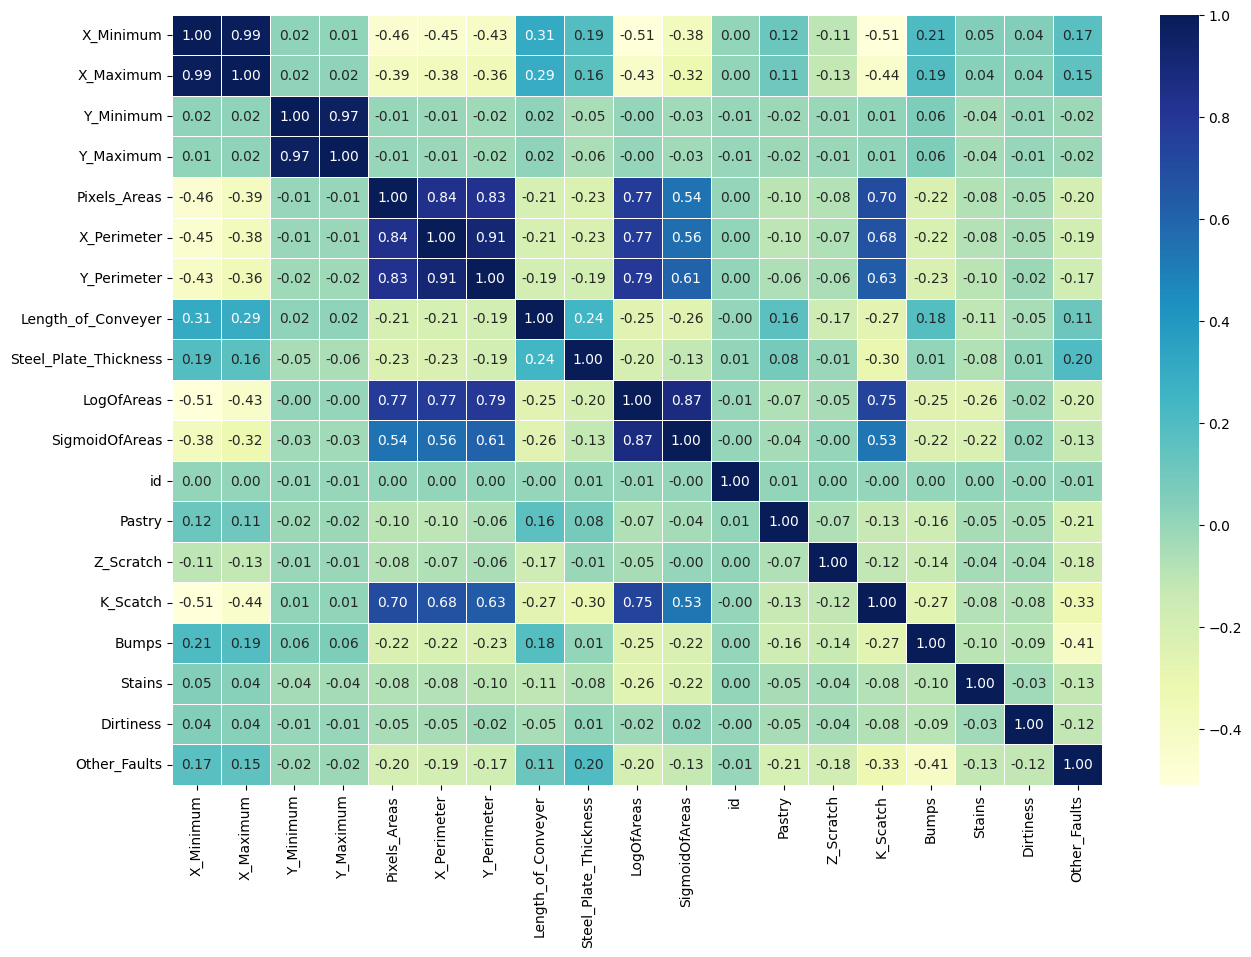

In [131]:
corr_matrix = df_size_targets.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,
                annot=True,
                linewidths=0.5,
                fmt='.2f',
                cmap= 'YlGnBu');

In [132]:
df_size_targets.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Length_of_Conveyer,Steel_Plate_Thickness,LogOfAreas,SigmoidOfAreas,id,Pastry,Z_Scratch,K_Scatch,Bumps,Stains,Dirtiness,Other_Faults
0,584,590,909972,909977,16,8,5,1358,50,1.2041,0.1417,0,0,0,0,0,1,0,0
1,808,816,728350,728372,433,20,54,1687,80,2.6365,0.9491,1,0,0,0,0,0,0,1
2,39,192,2212076,2212144,11388,705,420,1400,40,4.0564,1.0000,2,0,0,1,0,0,0,0
3,781,789,3353146,3353173,210,16,29,1387,40,2.3222,0.4025,3,0,0,1,0,0,0,0
4,1540,1560,618457,618502,521,72,67,1692,300,2.7694,0.9998,4,0,0,0,0,0,0,1


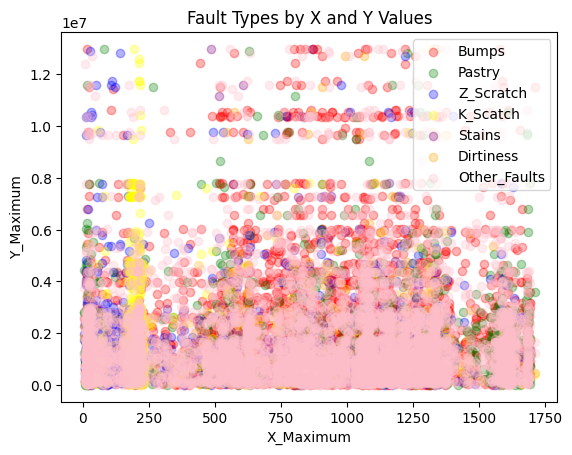

In [133]:
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'pink']
fault_types = ['Bumps', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Other_Faults']

for i, fault_type in enumerate(fault_types):
    plt.scatter(df_size_targets[df_size_targets[fault_type] == 1]['X_Maximum'], df_size_targets[df_size_targets[fault_type] == 1]['Y_Maximum'], c=colors[i], alpha = .3)

plt.xlabel('X_Maximum')
plt.ylabel('Y_Maximum')
plt.title('Fault Types by X and Y Values')
plt.legend(fault_types)
plt.show()

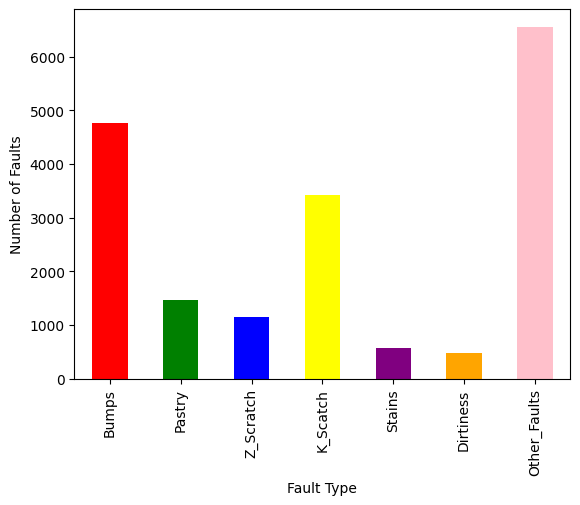

In [134]:
# @title Fault Type Comparison
df_size_targets[['Bumps', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Other_Faults']].sum().plot(kind='bar', stacked=True, color = colors)
plt.xlabel('Fault Type')
_ = plt.ylabel('Number of Faults')

In [135]:
train_df.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,x_by_y,Pixel_area_by_luminosity
0,0,584,590,909972,909977,16,8,5,2274,113,...,0.1417,0,0,0,1,0,0,0,1.600000,0.007036
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.9491,0,0,0,0,0,0,1,0.370370,0.009735
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,1.0000,0,0,1,0,0,0,0,1.678571,0.008684
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0.4025,0,0,1,0,0,0,0,0.551724,0.065584
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0.9998,0,0,0,0,0,0,1,1.074627,0.010802


In [136]:
train_df['sum_of_faults'] = train_df[['Bumps','Pastry','Z_Scratch','K_Scatch','Stains','Dirtiness','Other_Faults']].sum(axis=1)
train_df.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,x_by_y,Pixel_area_by_luminosity,sum_of_faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,0,0,0,1,0,0,0,1.600000,0.007036,1
1,1,808,816,728350,728372,433,20,54,44478,70,...,0,0,0,0,0,0,1,0.370370,0.009735,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,0,0,1,0,0,0,0,1.678571,0.008684,1
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0,0,1,0,0,0,0,0.551724,0.065584,1
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0,0,0,0,0,0,1,1.074627,0.010802,1


In [137]:
train_df['sum_of_faults'].value_counts()

1    18380
0      818
2       21
Name: sum_of_faults, dtype: int64

In [138]:
# prompt: see the rows with 2 in the value of sum of faults

train_df[train_df['sum_of_faults'] == 2]


,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,x_by_y,Pixel_area_by_luminosity,sum_of_faults
634,634,41,192,1682722,1682891,9927,578,343,1098162,29,...,0,0,1,0,0,0,1,1.685131,0.009040,2
752,752,39,194,2134009,2134076,10904,562,360,1130960,32,...,0,0,1,0,0,0,1,1.561111,0.009641,2
3572,3572,241,360,938265,938349,2027,178,118,241083,38,...,0,0,1,0,0,1,0,1.508475,0.008408,2
4416,4416,39,729,498078,498335,13114,976,453,1438454,29,...,0,0,1,0,0,0,1,2.154525,0.009117,2
4530,4530,39,222,221142,2212144,10166,634,383,1130960,31,...,0,0,1,0,0,0,1,1.655352,0.008989,2
4664,4664,39,218,7430,7458,21321,758,441,2256472,22,...,0,0,1,0,0,0,1,1.718821,0.009449,2
6448,6448,41,192,92878,92896,11211,572,357,1402972,31,...,0,0,1,0,0,0,1,1.602241,0.007991,2
7589,7589,41,776,844714,844903,11711,822,497,1351903,25,...,0,0,1,0,0,0,1,1.653924,0.008663,2
8075,8075,41,193,1725027,1725163,10941,639,409,1270726,40,...,0,0,1,0,0,0,1,1.562347,0.008610,2
8538,8538,39,215,1512277,1512467,13033,709,424,1508093,26,...,0,0,1,0,0,0,1,1.672170,0.008642,2


In [139]:
# try predicting the number of faults as a way to make better predictions
train_df.drop(targets,axis = 1)
train_df.drop(['Y_Minimum', 'Y_Maximum','Maximum_of_Luminosity', 'Luminosity_Index','Empty_Index','Edges_X_Index','Square_Index'], axis = 1, inplace = True)

In [140]:
train_df.head()

,id,X_Minimum,X_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,...,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,x_by_y,Pixel_area_by_luminosity,sum_of_faults
0,0,584,590,16,8,5,2274,113,1358,0,...,0,0,0,1,0,0,0,1.600000,0.007036,1
1,1,808,816,433,20,54,44478,70,1687,1,...,0,0,0,0,0,0,1,0.370370,0.009735,1
2,2,39,192,11388,705,420,1311391,29,1400,0,...,0,0,1,0,0,0,0,1.678571,0.008684,1
3,3,781,789,210,16,29,3202,114,1387,0,...,0,0,1,0,0,0,0,0.551724,0.065584,1
4,4,1540,1560,521,72,67,48231,82,1692,0,...,0,0,0,0,0,0,1,1.074627,0.010802,1


In [141]:
x = train_df.drop('sum_of_faults', axis = 1)
y = train_df['sum_of_faults']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9)


In [142]:
clf = Pipeline([
    ('scaler', StandardScaler()),
    ('lgbm', LGBMClassifier())
])

In [143]:
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4387
[LightGBM] [Info] Number of data points in the train set: 15375, number of used features: 30
[LightGBM] [Info] Start training from score -3.155863
[LightGBM] [Info] Start training from score -0.044691
[LightGBM] [Info] Start training from score -6.807285
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

0.9992195629552549

Most of the time there is only one type of fault with no more than 2. At the end the model should reflect this. I will train the model to predict each target indipendently first.

### Sample Modeling
## Models to try:


*   KNN
*   Random Forest Classifier
*   ADA Boost
*   Gradient Boost
*   LGBM
*   Deep learning model to be decided

## First need to scale the data







In [144]:
train_df.drop('sum_of_faults',axis = 1, inplace = True)

In [145]:
# create a pipeline for KNN
clf = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])


In [146]:
# split the data
x = train_df.drop(targets, axis = 1)
y = targets_df['Bumps']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9)


In [147]:
# train model
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

0.7414151925078044

In [148]:
def score_each_target(df):
  #split into test train split
  x = df.drop(targets, axis=1)
  y = df[targets].drop('id',axis=1)
  for col in y.columns:
    #create a data frame of each target value
    z = y[col]
    #split the data
    x_train, x_test, y_train, y_test = train_test_split(x, z, test_size=0.2, random_state=9)
    #train model
    clf.fit(x_train, y_train)
    #score model
    score = clf.score(x_test, y_test)
    AUC = roc_auc_score(y_test, clf.predict_proba(x_test)[:,1])
    print(col, score, AUC)

In [149]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19219 entries, 0 to 19218
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        19219 non-null  int64  
 1   X_Minimum                 19219 non-null  int64  
 2   X_Maximum                 19219 non-null  int64  
 3   Pixels_Areas              19219 non-null  int64  
 4   X_Perimeter               19219 non-null  int64  
 5   Y_Perimeter               19219 non-null  int64  
 6   Sum_of_Luminosity         19219 non-null  int64  
 7   Minimum_of_Luminosity     19219 non-null  int64  
 8   Length_of_Conveyer        19219 non-null  int64  
 9   TypeOfSteel_A300          19219 non-null  int64  
 10  TypeOfSteel_A400          19219 non-null  int64  
 11  Steel_Plate_Thickness     19219 non-null  int64  
 12  Edges_Index               19219 non-null  float64
 13  Outside_X_Index           19219 non-null  float64
 14  Edges_

In [150]:
# score_each_target(train_df)

In [151]:
# clf = Pipeline([
#     #('scaler', StandardScaler()),
#     ('RandomForestClassifier',RandomForestClassifier(class_weight='balanced'))
# ])

In [152]:
# score_each_target(train_df)

In [153]:
# clf = Pipeline([
#     ('scaler', StandardScaler()),
#     ('LGBM',LGBMClassifier(class_weight='balanced'))
# ])

In [154]:
# score_each_target(train_df)

In [155]:
# clf = Pipeline([
#     #('scaler', StandardScaler()),
#     ('ADA Boost',AdaBoostClassifier())
# ])

In [156]:
# score_each_target(train_df)

In [157]:
clf = Pipeline([
    ('scaler', StandardScaler()),
    ('Gradient Boost',GradientBoostingClassifier())
])

In [158]:
score_each_target(train_df)

Pastry 0.918834547346514 0.8752360262136403
Z_Scratch 0.9547346514047866 0.9564302253378908
K_Scatch 0.9612382934443289 0.9854502124606704
Bumps 0.7783558792924038 0.8159312366315457
Stains 0.9869927159209158 0.991509545576768
Dirtiness 0.9716441207075962 0.8771087252766846
Other_Faults 0.6802809573361083 0.6947906579809658


In [159]:
test_df = pd.read_csv('drive/MyDrive/Colab Notebooks/test_steel_plate.csv')

In [160]:
test_df.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,19219,1015,1033,3826564,3826588,659,23,46,62357,67,...,0.0095,0.5652,1.0000,1.0,2.8410,1.1139,1.6628,0.6727,-0.2261,0.9172
1,19220,1257,1271,419960,419973,370,26,28,39293,92,...,0.0047,0.2414,1.0000,1.0,2.5682,0.9031,1.4472,0.9063,-0.1453,0.9104
2,19221,1358,1372,117715,117724,289,36,32,29386,101,...,0.0155,0.6000,0.7500,0.0,2.4609,1.3222,1.3222,-0.5238,-0.0435,0.6514
3,19222,158,168,232415,232440,80,10,11,8586,107,...,0.0037,0.8000,1.0000,1.0,1.9031,0.6990,1.0414,0.1818,-0.0738,0.2051
4,19223,559,592,544375,544389,140,19,15,15524,103,...,0.0158,0.8421,0.5333,0.0,2.1461,1.3222,1.1461,-0.5714,-0.0894,0.4170


In [161]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12814 entries, 0 to 12813
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     12814 non-null  int64  
 1   X_Minimum              12814 non-null  int64  
 2   X_Maximum              12814 non-null  int64  
 3   Y_Minimum              12814 non-null  int64  
 4   Y_Maximum              12814 non-null  int64  
 5   Pixels_Areas           12814 non-null  int64  
 6   X_Perimeter            12814 non-null  int64  
 7   Y_Perimeter            12814 non-null  int64  
 8   Sum_of_Luminosity      12814 non-null  int64  
 9   Minimum_of_Luminosity  12814 non-null  int64  
 10  Maximum_of_Luminosity  12814 non-null  int64  
 11  Length_of_Conveyer     12814 non-null  int64  
 12  TypeOfSteel_A300       12814 non-null  int64  
 13  TypeOfSteel_A400       12814 non-null  int64  
 14  Steel_Plate_Thickness  12814 non-null  int64  
 15  Ed

In [162]:
test_df.describe()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
count,12814.000000,12814.000000,12814.000000,1.281400e+04,1.281400e+04,12814.000000,12814.000000,12814.000000,1.281400e+04,12814.000000,...,12814.000000,12814.000000,12814.000000,12814.000000,12814.000000,12814.000000,12814.000000,12814.000000,12814.000000,12814.000000
mean,25625.500000,709.331356,753.274934,1.846533e+06,1.842029e+06,1672.908225,96.459497,64.730607,1.926893e+05,84.548072,...,0.030695,0.618650,0.833823,0.584985,2.472743,1.311689,1.388119,0.101164,-0.139516,0.572401
std,3699.227509,531.878508,500.743570,1.916427e+06,1.911426e+06,3725.518996,219.928548,188.506385,4.812871e+05,28.711574,...,0.048663,0.220361,0.220306,0.483308,0.761108,0.467621,0.401725,0.488127,0.117878,0.331974
min,19219.000000,0.000000,4.000000,6.712000e+03,6.724000e+03,4.000000,2.000000,2.000000,5.350000e+02,0.000000,...,0.001500,0.014400,0.066700,0.000000,0.778200,0.344400,0.301000,-0.991000,-0.998900,0.119000
25%,22422.250000,46.000000,214.000000,6.401738e+05,6.398570e+05,91.000000,15.000000,14.000000,9.968000e+03,68.000000,...,0.006600,0.455075,0.666700,0.000000,1.959000,1.000000,1.079200,-0.277800,-0.192600,0.257000
50%,25625.500000,776.000000,796.000000,1.378890e+06,1.378588e+06,169.000000,24.000000,24.000000,1.840200e+04,90.000000,...,0.009500,0.638700,0.967700,1.000000,2.227900,1.146100,1.322200,0.111100,-0.143900,0.472900
75%,28828.750000,1152.000000,1167.000000,2.368032e+06,2.356238e+06,649.000000,64.000000,60.000000,6.696025e+04,105.000000,...,0.019075,0.785700,1.000000,1.000000,2.814125,1.431400,1.707600,0.529400,-0.084300,0.999200
max,32032.000000,1688.000000,1712.000000,1.298766e+07,1.298769e+07,152655.000000,10449.000000,18152.000000,1.159141e+07,203.000000,...,0.747200,1.000000,1.000000,1.000000,4.680200,2.938500,4.258700,0.973900,0.591700,1.000000


In [163]:
test_df['x_by_y'] = test_df['X_Perimeter'] / test_df['Y_Perimeter']

In [164]:
test_df['Pixel_area_by_luminosity'] = test_df['Pixels_Areas'] / test_df['Sum_of_Luminosity']

In [165]:
test_df.shape

(12814, 30)

In [166]:
test_df = test_df.drop('id',axis = 1)

In [167]:
test_df.drop(['Y_Minimum', 'Y_Maximum','Maximum_of_Luminosity', 'Luminosity_Index','Empty_Index','Edges_X_Index','Square_Index'], axis=1,inplace=True)

In [168]:
x.shape

(19219, 22)

In [169]:
predictions = pd.DataFrame(columns=targets)
predictions.drop(columns='id',inplace=True)

In [170]:
predictions.head()

,Pastry,Z_Scratch,K_Scatch,Bumps,Stains,Dirtiness,Other_Faults


In [171]:
def predict_each_target(df_train, df_test, predictions, clf):
    for col in predictions:
        z = df_train[col]
        x = df_train.drop(columns=targets)
        clf.fit(x, z)
        x_t = df_test
        predictions[col] = clf.predict_proba(x_t)[:,1]
        df_train[col] = predictions[col]
    return predictions

In [172]:
predictions = predict_each_target(train_df,test_df,predictions,clf)

In [173]:
# create submission file
df_test = pd.read_csv('drive/MyDrive/Colab Notebooks/test_steel_plate.csv')
df_test = pd.concat([df_test,predictions],axis=1)
df_test.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Bumps,Stains,Dirtiness,Other_Faults
0,19219,1015,1033,3826564,3826588,659,23,46,62357,67,...,0.6727,-0.2261,0.9172,0.596799,0.001770,0.004491,0.140902,0.000933,0.014472,0.387342
1,19220,1257,1271,419960,419973,370,26,28,39293,92,...,0.9063,-0.1453,0.9104,0.255418,0.035381,0.023678,0.206636,0.000981,0.131765,0.286317
2,19221,1358,1372,117715,117724,289,36,32,29386,101,...,-0.5238,-0.0435,0.6514,0.005839,0.025121,0.030385,0.338324,0.000942,0.008775,0.451949
3,19222,158,168,232415,232440,80,10,11,8586,107,...,0.1818,-0.0738,0.2051,0.121109,0.001775,0.002501,0.294422,0.001712,0.019099,0.431662
4,19223,559,592,544375,544389,140,19,15,15524,103,...,-0.5714,-0.0894,0.4170,0.003543,0.005391,0.003498,0.618633,0.001595,0.006417,0.375854


In [174]:
df_test_submission = df_test[targets]
df_test_submission[['id','Bumps','Pastry','Z_Scratch','K_Scatch','Stains', 'Dirtiness','Other_Faults']]
df_test_submission.head()

,id,Pastry,Z_Scratch,K_Scatch,Bumps,Stains,Dirtiness,Other_Faults
0,19219,0.596799,0.001770,0.004491,0.140902,0.000933,0.014472,0.387342
1,19220,0.255418,0.035381,0.023678,0.206636,0.000981,0.131765,0.286317
2,19221,0.005839,0.025121,0.030385,0.338324,0.000942,0.008775,0.451949
3,19222,0.121109,0.001775,0.002501,0.294422,0.001712,0.019099,0.431662
4,19223,0.003543,0.005391,0.003498,0.618633,0.001595,0.006417,0.375854


In [175]:
# move `Bumps` to the front of df_test_submission
cols = ['id','Bumps','Pastry','Z_Scratch','K_Scatch','Stains', 'Dirtiness','Other_Faults']
df_test_submission = df_test_submission[cols]
df_test_submission.head()

,id,Bumps,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Other_Faults
0,19219,0.140902,0.596799,0.001770,0.004491,0.000933,0.014472,0.387342
1,19220,0.206636,0.255418,0.035381,0.023678,0.000981,0.131765,0.286317
2,19221,0.338324,0.005839,0.025121,0.030385,0.000942,0.008775,0.451949
3,19222,0.294422,0.121109,0.001775,0.002501,0.001712,0.019099,0.431662
4,19223,0.618633,0.003543,0.005391,0.003498,0.001595,0.006417,0.375854


In [176]:
df_test_submission.to_csv('drive/MyDrive/Colab Notebooks/submission_no_reduction.csv',index=False)

In [177]:
# import train data again to start fresh
train_df = pd.read_csv('drive/MyDrive/train_steel_plate.csv')
train_df['sum_of_faults'] = train_df[['Bumps','Pastry','Z_Scratch','K_Scatch','Stains','Dirtiness','Other_Faults']].sum(axis=1)
train_df.drop(targets, axis = 1, inplace = True)
train_df.head(20)


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,sum_of_faults
0,584,590,909972,909977,16,8,5,2274,113,140,...,1.0000,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,-0.0104,0.1417,1
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.2500,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,-0.2997,0.9491,1
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,0.2363,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,-0.0944,1.0000,1
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.3750,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,-0.0402,0.4025,1
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.2105,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,-0.2455,0.9998,1
5,1009,1033,899231,899307,409,22,26,47513,86,118,...,0.5454,1.0000,1.0,2.6117,0.9542,1.4150,0.5909,-0.1890,0.8749,1
6,596,607,739072,7390760,204,21,21,22478,89,127,...,0.7143,1.0000,1.0,2.3096,1.1761,1.3222,0.3158,-0.1497,0.5212,1
7,1673,1687,294065,294091,571,38,57,53142,77,110,...,0.5686,0.7179,1.0,2.7528,1.3802,1.7559,0.0357,-0.2661,0.9408,1
8,507,521,203252,203261,101,25,12,12530,124,140,...,0.8000,0.7500,0.0,2.0043,1.3802,0.7782,-0.6667,0.0305,0.3601,0
9,893,907,1341292,1341296,54,6,15,7052,87,133,...,0.8333,1.0000,1.0,1.7324,0.6990,1.1761,0.4667,-0.1228,0.1400,1


In [178]:
x = train_df.drop('sum_of_faults', axis = 1)
y = train_df['sum_of_faults']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=9)
clf = LGBMClassifier(num_class=3,class_weight='balanced')
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5195
[LightGBM] [Info] Number of data points in the train set: 15375, number of used features: 27
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


0.9021852237252862

In [179]:
y_pred = clf.predict(x_test)

In [180]:
 print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.09      0.13      0.11       164
           1       0.96      0.94      0.95      3676
           2       0.00      0.00      0.00         4

    accuracy                           0.90      3844
   macro avg       0.35      0.36      0.35      3844
weighted avg       0.92      0.90      0.91      3844



In [181]:
clf.score(x,y)
y_preds = clf.predict(x)

In [182]:
y_preds_series = pd.Series(y_preds)
y_preds_series.value_counts()

1    17778
0     1424
2       17
dtype: int64

In [183]:
y.value_counts()

1    18380
0      818
2       21
Name: sum_of_faults, dtype: int64

In [184]:
#test_df['num_of_faults_predicted'] = clf.predict(test_df)

In [185]:
test_df.head()

,X_Minimum,X_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,...,Outside_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,SigmoidOfAreas,x_by_y,Pixel_area_by_luminosity
0,1015,1033,659,23,46,62357,67,1656,0,1,...,0.0095,1.0000,1.0,2.8410,1.1139,1.6628,0.6727,0.9172,0.500000,0.010568
1,1257,1271,370,26,28,39293,92,1354,0,1,...,0.0047,1.0000,1.0,2.5682,0.9031,1.4472,0.9063,0.9104,0.928571,0.009416
2,1358,1372,289,36,32,29386,101,1360,0,1,...,0.0155,0.7500,0.0,2.4609,1.3222,1.3222,-0.5238,0.6514,1.125000,0.009835
3,158,168,80,10,11,8586,107,1690,1,0,...,0.0037,1.0000,1.0,1.9031,0.6990,1.0414,0.1818,0.2051,0.909091,0.009317
4,559,592,140,19,15,15524,103,1688,1,0,...,0.0158,0.5333,0.0,2.1461,1.3222,1.1461,-0.5714,0.4170,1.266667,0.009018


In [186]:
#test_df['num_of_faults_predicted'].value_counts()

In [187]:
df_test_submission = df_test[targets]
df_test_submission.head()


,id,Pastry,Z_Scratch,K_Scatch,Bumps,Stains,Dirtiness,Other_Faults
0,19219,0.596799,0.001770,0.004491,0.140902,0.000933,0.014472,0.387342
1,19220,0.255418,0.035381,0.023678,0.206636,0.000981,0.131765,0.286317
2,19221,0.005839,0.025121,0.030385,0.338324,0.000942,0.008775,0.451949
3,19222,0.121109,0.001775,0.002501,0.294422,0.001712,0.019099,0.431662
4,19223,0.003543,0.005391,0.003498,0.618633,0.001595,0.006417,0.375854


Somewhat underpredicting the number of faults. Still need to try and use this for the final predictions. Right now I think that if the predicted number is 1 the model should predict the between `K_Scatch` `Other_Faults`, and `Bumps` as those are the dominant fault types

In [188]:
#test_df[test_df['num_of_faults_predicted']>1]



In [189]:
df_test_submission[9295:]

,id,Pastry,Z_Scratch,K_Scatch,Bumps,Stains,Dirtiness,Other_Faults
9295,28514,0.004831,0.001415,0.957395,0.009027,0.000891,0.002539,0.070462
9296,28515,0.063364,0.003357,0.003096,0.395963,0.000933,0.031630,0.396316
9297,28516,0.010447,0.748040,0.002860,0.082439,0.000908,0.003161,0.277950
9298,28517,0.059879,0.009372,0.028385,0.495803,0.001403,0.023449,0.297336
9299,28518,0.174394,0.001173,0.002422,0.439376,0.001677,0.009819,0.368661
...,...,...,...,...,...,...,...,...
12809,32028,0.061561,0.101354,0.005633,0.181263,0.001001,0.032855,0.381288
12810,32029,0.174027,0.007256,0.031408,0.217545,0.008170,0.121297,0.458485
12811,32030,0.003581,0.001365,0.946504,0.009027,0.000891,0.001905,0.068398
12812,32031,0.298549,0.014752,0.028099,0.215582,0.000889,0.062491,0.309114


In [190]:
# prompt: Using dataframe df_test_submission: check to see if multiple columns have above a .5 value
df_test_submission['fault_count'] = df_test_submission.iloc[:, 1:8].gt(0.5).sum(axis=1)
df_test_submission.head()

,id,Pastry,Z_Scratch,K_Scatch,Bumps,Stains,Dirtiness,Other_Faults,fault_count
0,19219,0.596799,0.001770,0.004491,0.140902,0.000933,0.014472,0.387342,1
1,19220,0.255418,0.035381,0.023678,0.206636,0.000981,0.131765,0.286317,0
2,19221,0.005839,0.025121,0.030385,0.338324,0.000942,0.008775,0.451949,0
3,19222,0.121109,0.001775,0.002501,0.294422,0.001712,0.019099,0.431662,0
4,19223,0.003543,0.005391,0.003498,0.618633,0.001595,0.006417,0.375854,1


In [191]:
df_test_submission['fault_count'].value_counts()

1    6768
0    6003
2      43
Name: fault_count, dtype: int64

In [192]:
df_test_submission[df_test_submission['fault_count'] > 2]


,id,Pastry,Z_Scratch,K_Scatch,Bumps,Stains,Dirtiness,Other_Faults,fault_count


In [193]:
# def fault_reduction(df):
#     if df['fault_count'].sum() > 1:
#         # Iterate through each row in the DataFrame
#         for index, row in df.iloc[1:].iterrows():
#             # Iterate through each column in the row
#             for col in df.columns:
#                 # Exclude the 'Other_Faults' and `fault_count` columns
#                 if col not in ['K_Scatch','Bumps','Other_faults' 'fault_count','id']:
#                     # Subtract 0.2 from the value in the current cell
#                     df.at[index, col] -= 0.3


#     return df

In [194]:
# fault_reduction(df_test_submission)
# # Using dataframe df_test_submission: check to see if multiple columns have above a .5 value
# df_test_submission['fault_count'] = df_test_submission.iloc[:, 1:8].gt(0.5).sum(axis=1)
# df_test_submission['fault_count'].value_counts()

In [195]:
# def fault_reduction_2(df):
#     if df['fault_count'].sum() > 1:
#         # Iterate through each row in the DataFrame
#         for index, row in df.iloc[1:].iterrows():
#             # Iterate through each column in the row
#             for col in df.columns:
#                 # Exclude the 'Other_Faults' and `fault_count` columns
#                 if col not in ['id','Other_Faults']:
#                     # Subtract 0.2 from the value in the current cell
#                     df.at[index, col] -= 0.1

#     return df

In [196]:
df_test_submission['Other_Faults'] = df_test_submission['Other_Faults'] + .2
df_test_submission.head()

,id,Pastry,Z_Scratch,K_Scatch,Bumps,Stains,Dirtiness,Other_Faults,fault_count
0,19219,0.596799,0.001770,0.004491,0.140902,0.000933,0.014472,0.587342,1
1,19220,0.255418,0.035381,0.023678,0.206636,0.000981,0.131765,0.486317,0
2,19221,0.005839,0.025121,0.030385,0.338324,0.000942,0.008775,0.651949,0
3,19222,0.121109,0.001775,0.002501,0.294422,0.001712,0.019099,0.631662,0
4,19223,0.003543,0.005391,0.003498,0.618633,0.001595,0.006417,0.575854,1


In [197]:
fault_reduction_2(df_test_submission)
# Using dataframe df_test_submission: check to see if multiple columns have above a .5 value
df_test_submission['fault_count'] = df_test_submission.iloc[:, 1:8].gt(0.5).sum(axis=1)
df_test_submission['fault_count'].value_counts()

1    10859
0     1285
2      669
3        1
Name: fault_count, dtype: int64

In [198]:
df_test_submission.shape

(12814, 9)

In [199]:
df_test_submission.head()

,id,Pastry,Z_Scratch,K_Scatch,Bumps,Stains,Dirtiness,Other_Faults,fault_count
0,19219,0.596799,0.001770,0.004491,0.140902,0.000933,0.014472,0.587342,2
1,19220,0.155418,-0.064619,-0.076322,0.106636,-0.099019,0.031765,0.486317,0
2,19221,-0.094161,-0.074879,-0.069615,0.238324,-0.099058,-0.091225,0.651949,1
3,19222,0.021109,-0.098225,-0.097499,0.194422,-0.098288,-0.080901,0.631662,1
4,19223,-0.096457,-0.094609,-0.096502,0.518633,-0.098405,-0.093583,0.575854,2


In [200]:
df_test_submission2 = df_test_submission.copy()
for col in df_test_submission2.columns:
  if col not in ['id','fault_count']:
    df_test_submission2[col] = df_test_submission2[col].apply(lambda x: 1 if x>0.5 else 0)
df_test_submission2.head()


,id,Pastry,Z_Scratch,K_Scatch,Bumps,Stains,Dirtiness,Other_Faults,fault_count
0,19219,1,0,0,0,0,0,1,2
1,19220,0,0,0,0,0,0,0,0
2,19221,0,0,0,0,0,0,1,1
3,19222,0,0,0,0,0,0,1,1
4,19223,0,0,0,1,0,0,1,2


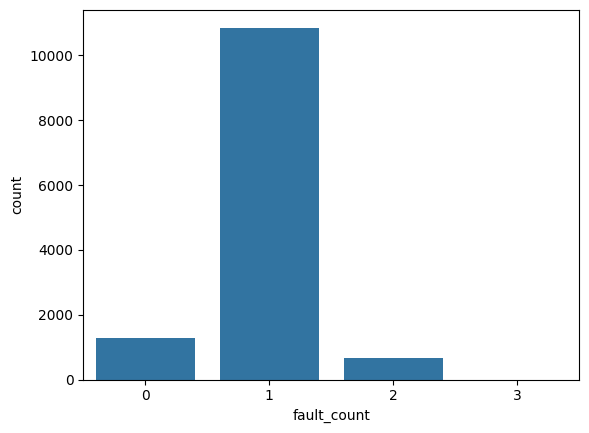

In [201]:
fig, ax = plt.subplots()
sns.countplot(x = 'fault_count', data = df_test_submission2)
plt.show()

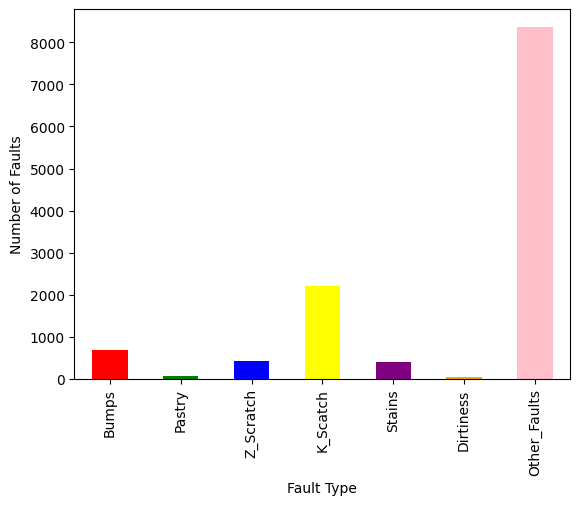

In [202]:
df_test_submission2[['Bumps', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Other_Faults']].sum().plot(kind='bar', stacked=True, color = colors)
plt.xlabel('Fault Type')
_ = plt.ylabel('Number of Faults')

In [203]:
# convert id column to int
df_test_submission['id'] = df_test_submission['id'].astype(int)

In [204]:
df_test_submission.drop('fault_count',axis=1,inplace=True)

In [205]:
df_test_submission.shape

(12814, 8)

In [206]:
# move `Bumps` to the front of df_test_submission
cols = ['id','Bumps','Pastry','Z_Scratch','K_Scatch','Stains', 'Dirtiness','Other_Faults']
df_test_submission = df_test_submission[cols]
df_test_submission.head()

,id,Bumps,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Other_Faults
0,19219,0.140902,0.596799,0.001770,0.004491,0.000933,0.014472,0.587342
1,19220,0.106636,0.155418,-0.064619,-0.076322,-0.099019,0.031765,0.486317
2,19221,0.238324,-0.094161,-0.074879,-0.069615,-0.099058,-0.091225,0.651949
3,19222,0.194422,0.021109,-0.098225,-0.097499,-0.098288,-0.080901,0.631662
4,19223,0.518633,-0.096457,-0.094609,-0.096502,-0.098405,-0.093583,0.575854


In [207]:
df_test_submission.to_csv('drive/MyDrive/Colab Notebooks/submission.csv',index=False)

In [208]:
df_test_submission.shape

(12814, 8)

In [209]:
# possible that the model predicts well for all categories except bumps and other faults which are the two most common categories...
# check and see how often/ if it predicts two categories. this should be minimal as very few had two
# faults.
# try some feature engineering and feature reduction